In [1]:
from Model import Model
import Parameters
import datetime
import numpy as np
import matplotlib.pyplot as plt
import pathlib
import pandas as pd
import Util
import cv2

In [2]:
def moving_average_compare(data):
    return Util.moving_average(data[0,0:,:])

In [3]:
def moving_average_compare_vaccine(data, index):
    return Util.moving_average(data[index,0,0:,:])

In [4]:
def compute_sdd(act, predict):
    difference = act - predict
    return np.sum(np.square(difference))

In [5]:
infectiousness = 0.09
m1 = Model(forecast_days=0, infectiousness=infectiousness)
m2 = Model(forecast_days=0, infectiousness=infectiousness, prior_immunity=0)
start_date = datetime.datetime(2020, 1, 15)
forecast_start_date = datetime.datetime(2022, 1, 1)
start_date = (forecast_start_date - start_date).days
print(start_date)
m1.date = start_date

0.2
0.2
717


(450,)


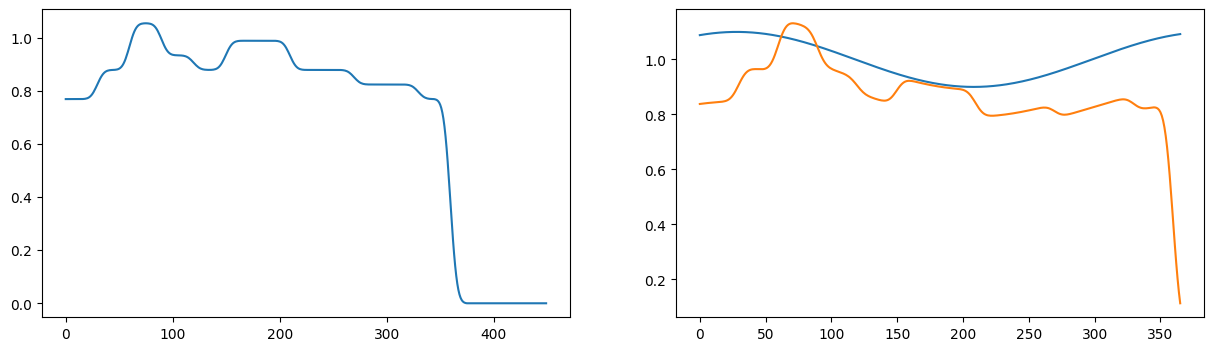

In [6]:
# monthly_multipliers = np.array([0.7, 0.85, 0.95, 0.9, 0.75, 0.9, 0.9, 0.8, 0.8, 0.75, 0.75, 0.7, 0.7])
monthly_multipliers = np.concatenate([np.array([0.7, 0.8, 0.96, 0.85, 0.8, 0.9, 0.9, 0.8, 0.8, 0.75, 0.75, 0.7, 0.7]) * 1.1, np.ones(shape=(12, ))])
augmented_multiplier = np.zeros(shape=(15 * 30))
for i in range(12):
    augmented_multiplier[30 * i:30 * (i+1)] = monthly_multipliers[i]

augmented_multiplier = cv2.GaussianBlur(augmented_multiplier.reshape(augmented_multiplier.shape[0], 1), (31, 31), 0).reshape(augmented_multiplier.shape[0], )

print(augmented_multiplier.shape)

final = Parameters.SEASONALITY[(forecast_start_date - Parameters.OUTBREAK_FIRST_DAY).days:1083] * augmented_multiplier[:1083 - start_date]

plt.figure(figsize=(15, 4))
plt.subplot(1, 2, 1)
plt.plot(augmented_multiplier)
plt.subplot(1, 2, 2)
plt.plot(Parameters.SEASONALITY[(forecast_start_date - Parameters.OUTBREAK_FIRST_DAY).days:1083])
plt.plot(final)
plt.show()

In [7]:
# def compute_previous_immunity():
#     for i in range(1083):
#         m1._compute_immunity(i)
#
#         if i % 200 == 10:
#
#             x = [Parameters.OUTBREAK_FIRST_DAY + datetime.timedelta(days=j) for j in range(1083)]
#             for j in range(16):
#                 slice = m1.model_data.time_series_immunity[0].T[j].T
#                 plt.plot(x, slice, label=j)
#             plt.legend()
#             plt.xticks(rotation=45, ha='right')
#             plt.title('Predicted immunity')
#             plt.show()
#         m2.print_data(m1.date)

# Pre-run plotting

(4, 528, 1083, 16)
(1077, 16)
(4, 528, 1083, 16)


C:\Users\loveb\AppData\Local\Temp\ipykernel_51432\3007877389.py:13: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,4,1), plt.plot([Parameters.OUTBREAK_FIRST_DAY + datetime.timedelta(days=j) for j in range(1083 - 6)], (np.mean(vaccinated1, axis=1))), plt.title('vaccine 1'),     plt.xticks(rotation=45, ha='right')


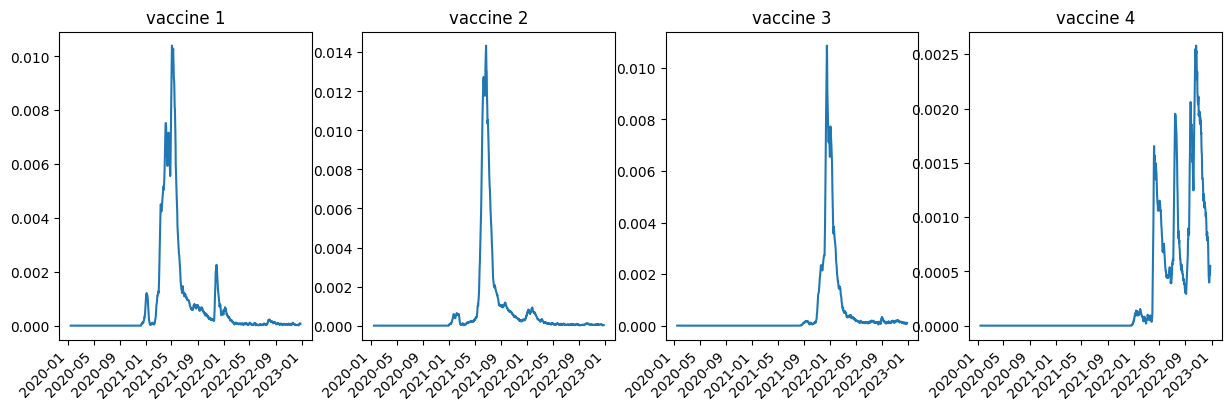

In [8]:
ground_truth_data = m2.model_data
immunity = moving_average_compare(ground_truth_data.time_series_immunity)
vaccinated1 = moving_average_compare_vaccine(ground_truth_data.time_series_vaccinated, 0)
vaccinated2 = moving_average_compare_vaccine(ground_truth_data.time_series_vaccinated, 1)
vaccinated3 = moving_average_compare_vaccine(ground_truth_data.time_series_vaccinated, 2)
vaccinated4 = moving_average_compare_vaccine(ground_truth_data.time_series_vaccinated, 3)

print(ground_truth_data.time_series_vaccinated.shape)
print(vaccinated1.shape)

plt.figure(figsize=(15,4))
plt.subplot()
plt.subplot(1,4,1), plt.plot([Parameters.OUTBREAK_FIRST_DAY + datetime.timedelta(days=j) for j in range(1083 - 6)], (np.mean(vaccinated1, axis=1))), plt.title('vaccine 1'),     plt.xticks(rotation=45, ha='right')
plt.subplot(1,4,2), plt.plot([Parameters.OUTBREAK_FIRST_DAY + datetime.timedelta(days=j) for j in range(1083 - 6)],  (np.mean(vaccinated2, axis=1))), plt.title('vaccine 2'),     plt.xticks(rotation=45, ha='right')
plt.subplot(1,4,3), plt.plot([Parameters.OUTBREAK_FIRST_DAY + datetime.timedelta(days=j) for j in range(1083 - 6)],  (np.mean(vaccinated3, axis=1))), plt.title('vaccine 3'),     plt.xticks(rotation=45, ha='right')
plt.subplot(1,4,4), plt.plot([Parameters.OUTBREAK_FIRST_DAY + datetime.timedelta(days=j) for j in range(1083 - 6)],  (np.mean(vaccinated4, axis=1))), plt.title('vaccine 4'),     plt.xticks(rotation=45, ha='right')
print((ground_truth_data.time_series_vaccinated).shape)

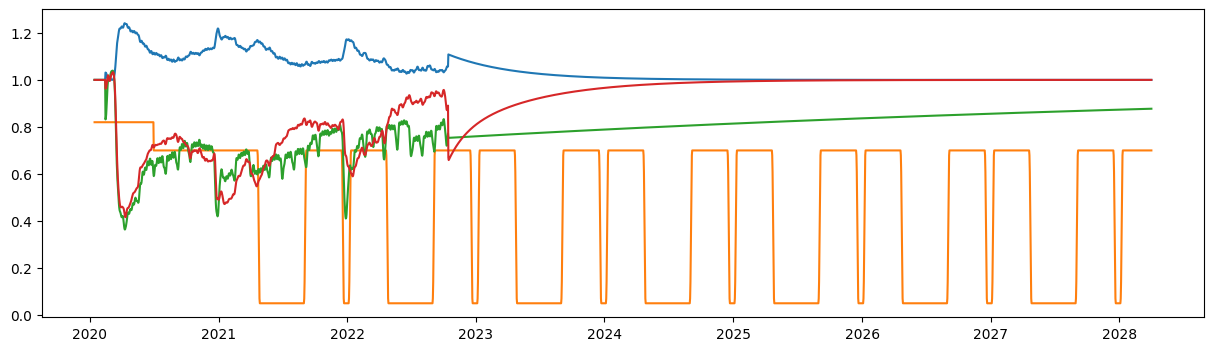

In [9]:
plt.figure(figsize=(15,4))
plt.plot([Parameters.OUTBREAK_FIRST_DAY + datetime.timedelta(days=j) for j in range(3000)], m1.dependency.mobility)

### Waning kernels

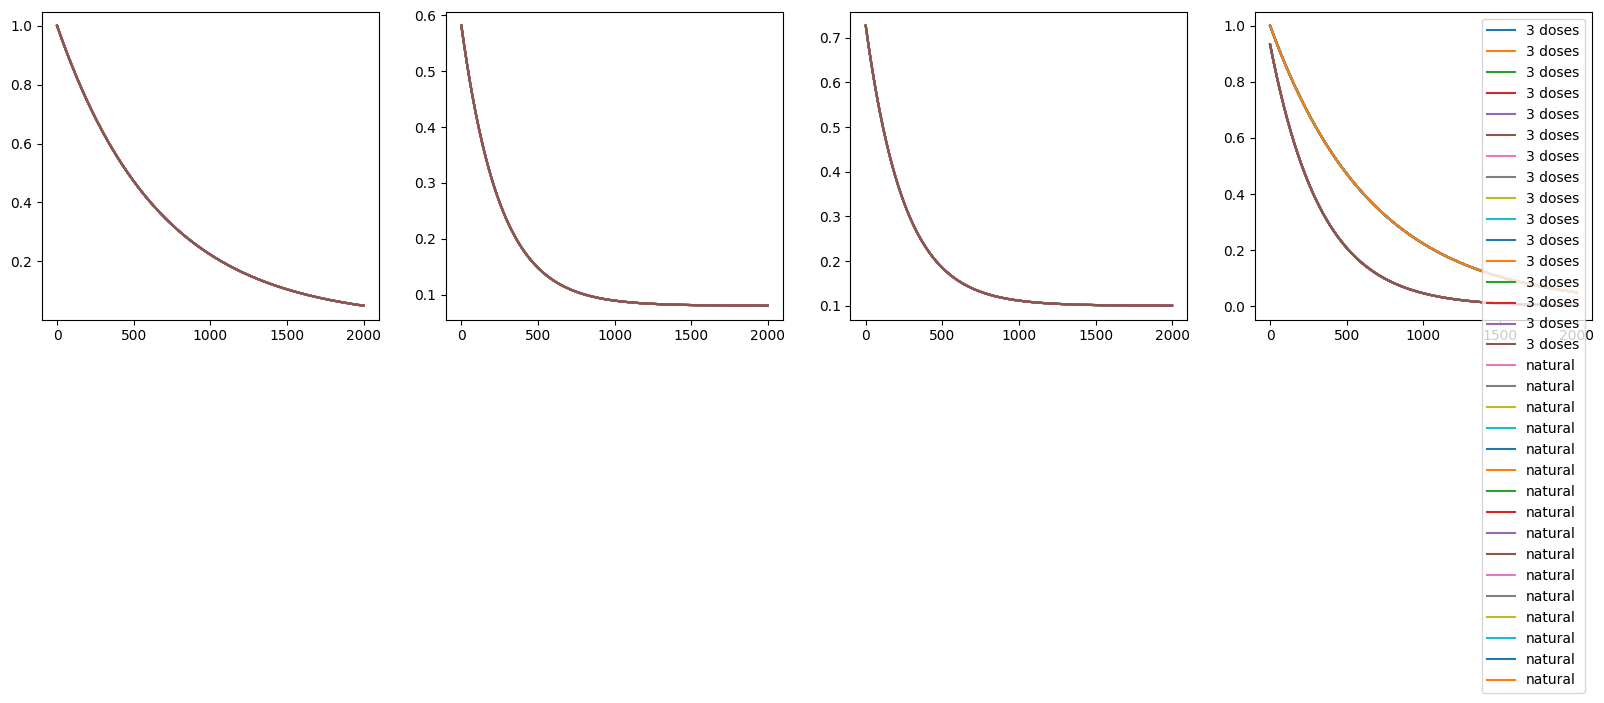

In [10]:
plt.figure(figsize=(20,4))
plt.subplot(1, 4, 1), plt.plot(Parameters.get_immunity_kernel(dose=0))
plt.subplot(1, 4, 2), plt.plot(Parameters.get_immunity_kernel(dose=1))
plt.subplot(1, 4, 3), plt.plot(Parameters.get_immunity_kernel(dose=2))
plt.subplot(1, 4, 4)
plt.plot(Parameters.get_immunity_kernel(dose=3), label='3 doses')
plt.plot(Parameters.get_immunity_kernel(dose=0) , label='natural')
plt.legend()
plt.show()

# Compute immunity!

In [11]:
# compute_previous_immunity()

## Run the model

In [12]:
for i in range(1083-m1.date-1):
    month = int(i / 30)
    multiplier = monthly_multipliers[month] * infectiousness
    m1.infectiousness = multiplier
    m1.run_one_cycle(display_status=False)
    if i % 50 == 10 or m1.date == 1071:

        x = [Parameters.OUTBREAK_FIRST_DAY + datetime.timedelta(days=j+start_date) for j in range(m1.date-start_date)]
        
        plt.figure(figsize=(15,4))
        plt.subplot()
        plt.subplot(1, 3, 1)
        plt.plot(x, np.sum((np.sum(m1.model_data.time_series_clinical_cases, axis=0))[start_date:m1.date], axis=1), color='red', label='Forecast')
        plt.plot(x, np.sum(((np.sum(m2.model_data.time_series_clinical_cases, axis=0)))[start_date:m1.date], axis=1), color='black', label='Ground_truth')
        plt.legend()
        plt.xticks(rotation=45, ha='right')
        plt.title('Clinical cases')
        plt.subplot(1, 3, 2)
        for j in range(8):
            slice = m1.model_data.time_series_immunity[0].T[j].T
            plt.plot(x, slice[start_date:m1.date], label=Parameters.AGE_BANDS[j])
        plt.legend()
        plt.xticks(rotation=45, ha='right')
        plt.title('Predicted immunity')
        plt.subplot(1, 3, 3)
        for j in range(8):
            slice = m1.model_data.time_series_immunity[0].T[j+8].T
            plt.plot(x, slice[start_date:m1.date], label=Parameters.AGE_BANDS[j+8])
        plt.legend()
        plt.xticks(rotation=45, ha='right')
        plt.title('Predicted immunity')
        plt.show()


        plt.figure(figsize=(15,4))
        plt.subplot(1, 2, 1)
        for j in range(8):
            slice = m1.model_data.time_series_vaccine_immunity[0].T[j].T
            plt.plot(x, slice[start_date:m1.date], label=Parameters.AGE_BANDS[j])
        plt.legend()
        plt.xticks(rotation=45, ha='right')
        plt.title('Vaccine immunity')
        plt.subplot(1, 2, 2)
        for j in range(8):
            slice = m1.model_data.time_series_vaccine_immunity[0].T[j+8].T
            plt.plot(x, slice[start_date:m1.date], label=Parameters.AGE_BANDS[j+8])
        plt.legend()
        plt.xticks(rotation=45, ha='right')
        plt.title('Vaccine immunity')
        plt.show()

        plt.figure(figsize=(15,4))
        plt.subplot(1, 2, 1)
        for j in range(8):
            slice = m1.model_data.time_series_infection_immunity[0].T[j].T
            plt.plot(x, slice[start_date:m1.date], label=Parameters.AGE_BANDS[j])
        plt.legend()
        plt.xticks(rotation=45, ha='right')
        plt.title('Infection immunity')
        plt.subplot(1, 2, 2)
        for j in range(8):
            slice = m1.model_data.time_series_infection_immunity[0].T[j+8].T
            plt.plot(x, slice[start_date:m1.date], label=Parameters.AGE_BANDS[j+8])
        plt.legend()
        plt.xticks(rotation=45, ha='right')
        plt.title('Infection immunity')
        plt.show()


        plt.figure(figsize=(15,4))
        plt.subplot()
        plt.subplot(1, 2, 1)
        plt.plot(x, np.sum((np.sum(m1.model_data.time_series_hospitalized, axis=0))[start_date:m1.date], axis=1), color='red', label='Forecast')
        plt.plot(x, np.sum((np.sum(m2.model_data.time_series_hospitalized, axis=0))[start_date:m1.date], axis=1), color='black', label='Ground_truth')
        plt.title('Hospitalized')
        plt.xticks(rotation=45, ha='right')
        plt.subplot(1, 2 ,2), plt.plot(np.mean(moving_average_compare_vaccine(m1.model_data.time_series_vaccinated, 2)[start_date:], axis=1)), plt.title('vaccine 3')
        plt.title('Actual vaccinated')
        plt.show()

        plt.figure(figsize=(15,4))
        plt.subplot(1, 2, 1)
        plt.plot(x, Parameters.SEASONALITY[start_date:m1.date])
        plt.plot(x, m1.dependency.mobility[start_date:m1.date])
        plt.xticks(rotation=45, ha='right')
        plt.subplot(1, 2, 2)
        matrix = m1._synthesize_matrix(contact_type=0, contact_pattern='day') + m1._synthesize_matrix(contact_type=0, contact_pattern='night')
        plt.imshow(matrix)
        plt.colorbar()
        plt.show()

        plt.figure(figsize=(15,4))
        plt.subplot(1, 4, 1), plt.plot(np.matmul(matrix.T, np.ones(shape=(16, 1))))
        plt.subplot(1, 4, 2), plt.plot(np.matmul(matrix, np.ones(shape=(16, 1))))
        plt.subplot(1, 4, 3), plt.plot(np.sum(matrix, axis=0))
        plt.subplot(1, 4, 4), plt.plot(np.sum(matrix, axis=1))
        plt.show()

In [ ]:
predicated_data = m1.model_data
ground_truth_clinical = moving_average_compare(m2.model_data.time_series_clinical_cases)
predicted_clinical = moving_average_compare(predicated_data.time_series_clinical_cases)
print(compute_sdd(ground_truth_clinical, predicted_clinical))

In [ ]:
x = [Parameters.OUTBREAK_FIRST_DAY + datetime.timedelta(days=j) for j in range(1066)]

plt.figure(figsize=(15,4))
plt.subplot()
plt.subplot(1, 2, 1), plt.plot(x, ground_truth_clinical)
plt.xticks(rotation=45, ha='right')
plt.subplot(1, 2, 2), plt.plot(x, predicted_clinical)
plt.xticks(rotation=45, ha='right')
plt.show()

In [ ]:
ground_truth_deaths = moving_average_compare(m2.model_data.time_series_deaths)
predicted_deaths = moving_average_compare(m1.model_data.time_series_deaths)
print(compute_sdd(ground_truth_deaths, predicted_deaths))

In [ ]:
plt.figure(figsize=(15,4))
plt.subplot()
plt.subplot(1, 2, 1), plt.plot(ground_truth_deaths)
plt.subplot(1, 2, 2), plt.plot(predicted_deaths)
plt.show()

In [ ]:
ground_truth_hosp = moving_average_compare(m2.model_data.time_series_hospitalized)
predicted_hosp = moving_average_compare(m1.model_data.time_series_hospitalized)
print(compute_sdd(ground_truth_hosp, predicted_hosp))

In [ ]:
plt.figure(figsize=(15,4))
plt.subplot()
plt.subplot(1, 2, 1), plt.plot(ground_truth_hosp)
plt.subplot(1, 2, 2), plt.plot(predicted_hosp)
plt.show()

In [ ]:
ground_truth_icu = moving_average_compare(m2.model_data.time_series_ICU)
predicted_icu = moving_average_compare(m1.model_data.time_series_ICU)
print(compute_sdd(ground_truth_icu, predicted_icu))

In [ ]:
plt.figure(figsize=(15,4))
plt.subplot()
plt.subplot(1, 2, 1), plt.plot(ground_truth_icu)
plt.subplot(1, 2, 2), plt.plot(predicted_icu)
plt.show()

In [ ]:
print(np.sum(m2.model_data.time_series_deaths))

In [ ]:
immunity = moving_average_compare(m1.model_data.time_series_immunity)
vaccine = moving_average_compare(m1.model_data.time_series_vaccinated)
plt.figure(figsize=(15,4))
plt.subplot()
plt.subplot(1, 2, 1), plt.plot(immunity)
plt.subplot(1, 2, 2), plt.plot(vaccine)

In [ ]:

plt.plot(np.sum(m1.model_data.time_series_vaccinated[0], axis=0).T, label=i)
plt.plot(np.sum(m1.model_data.time_series_vaccinated[1], axis=0).T, label=i)
plt.plot(np.sum(m1.model_data.time_series_vaccinated[2], axis=0).T, label=i)
plt.legend()
plt.show()

In [ ]:
for i in range(16):
    slice = m1.model_data.time_series_immunity[0].T[i].T
    plt.plot(slice, label=i)
plt.legend()
plt.show()

In [ ]:

slice = m1.model_data.time_series_vaccinated[0].T[15].T
plt.plot(slice, color='black')
slice = m1.model_data.time_series_vaccinated[0].T[14].T
slice = m1.model_data.time_series_vaccinated[0].T[13].T
slice = m1.model_data.time_series_vaccinated[0].T[12].T
slice = m1.model_data.time_series_vaccinated[0].T[11].T
plt.plot(slice)
plt.show()

In [ ]:
for i in range(16):
    slice = m1.model_data.time_series_active_cases[0].T[5].T
    plt.plot(slice, label=i)
plt.legend()
plt.show()

In [ ]:
# m1.save_to_file()